<a href="https://colab.research.google.com/github/Jaimemorillo/covid-assignment/blob/main/survival_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/MyDrive/covid_assignment/COVID19_data.csv'

In [ ]:
%pip install lifelines

     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=05ed351e3b31eba9737684e6cf9fd19125fa4d40cd8df789fcf74caaf0206b52
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter 
from lifelines.statistics import (logrank_test, pairwise_logrank_test, multivariate_logrank_test, 
                                  survival_difference_at_fixed_point_in_time_test)

plt.style.use('seaborn')

# Kaplan-Meier

The estimator is defined as the fraction of observations who survived for a certain amount of time under the same circumstances 

https://towardsdatascience.com/introduction-to-survival-analysis-the-kaplan-meier-estimator-94ec5812a97a

## Kaplan-Meier Curves
A plot of the Kaplan-Meier estimator over time. We can use those curves as an exploratory tool — to compare the survival function between cohorts, groups that received some kind of treatment or not, behavioral clusters, etc.

In [ ]:
df = pd.read_csv(data_path)

In [ ]:
df

,ID,AGE,SEX,DAYS_HOSPITAL,DAYS_ICU,EXITUS,DESTINATION,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
0,1,15.0,FEMALE,4,0,NO,NaN,37.0,0,0,92,0,0
1,2,18.0,FEMALE,4,0,NO,ADMISSION,37.3,105,0,97,0,0
2,3,21.0,MALE,7,0,NO,NaN,38.5,112,0,95,85,47
3,4,21.0,MALE,10,0,NO,ADMISSION,39.2,113,0,97,0,0
4,5,22.0,MALE,4,0,NO,NaN,36.3,80,0,92,111,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,2050,189.0,FEMALE,11,3,NO,ADMISSION,0.0,0,0,0,0,0
2050,2051,NaN,FEMALE,3,0,NO,NaN,36.5,0,0,0,0,0
2051,2052,NaN,FEMALE,6,6,NO,NaN,36.8,190,0,98,0,0
2052,2053,NaN,MALE,5,0,NO,NaN,0.0,120,0,93,0,0


In [ ]:
df.loc[:, 'DAYS_TOTAL'] = df.DAYS_HOSPITAL + df.DAYS_ICU

In [ ]:
df.EXITUS.value_counts(dropna=False)

NO     1684
YES     329
NaN      41
Name: EXITUS, dtype: int64

Discard null values. We don't know if they are die or alive.

In [ ]:
df = df[~pd.isnull(df.EXITUS)]

In [ ]:
df.loc[:,'DIE'] = df['EXITUS'].apply(lambda x: 1 if x=='NO' else 0)

In [ ]:
df.SEX.value_counts(dropna=False)

MALE      1209
FEMALE     802
NaN          2
Name: SEX, dtype: int64

In [ ]:
df = df[~pd.isnull(df.SEX)]

In [ ]:
len(df[pd.isnull(df.AGE)])

4

In [ ]:
df = df[~pd.isnull(df.AGE)]

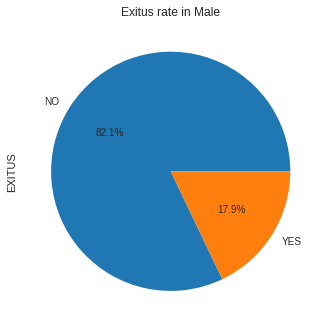

In [ ]:
df[df.SEX=='MALE'].EXITUS.value_counts().plot(kind='pie', 
                                              title='Exitus rate in Male', 
                                              autopct='%1.1f%%',colors=['tab:blue', 'tab:orange'])

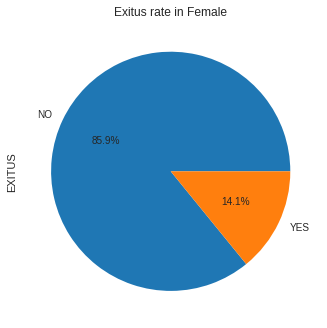

In [ ]:
df[df.SEX=='FEMALE'].EXITUS.value_counts().plot(kind='pie', 
                                              title='Exitus rate in Female', 
                                              autopct='%1.1f%%',colors=['tab:blue', 'tab:orange'])

## Survival curve (general)

### Plot

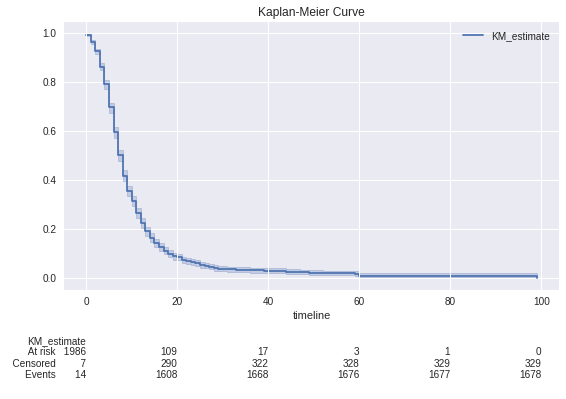

In [ ]:
T = df['DAYS_TOTAL']
E = df['DIE']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve');

Median survival time: the point in time in which on average 50% of the population has already died.

In [ ]:
kmf.median_survival_time_

8.0

## Survival curves by sex

### Plot

Median survival time of FEMALE: 7.0
Median survival time of MALE: 8.0


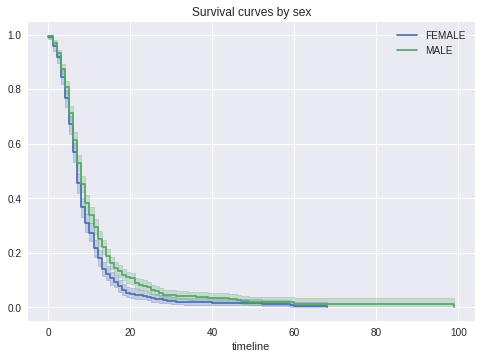

In [ ]:
ax = plt.subplot()

kmf = KaplanMeierFitter()

for sex in df['SEX'].unique():
  flag = df['SEX'] == sex
    
  kmf.fit(T[flag], event_observed=E[flag], label=sex)
  kmf.plot(ax=ax)
  print('Median survival time of ' + sex + ': ' + str(kmf.median_survival_time_))

plt.title("Survival curves by sex");

### Logrank test

https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html

In [ ]:
male_flag = df['SEX'] == 'MALE'
female_flag = df['SEX'] == 'FEMALE'

results = logrank_test(T[male_flag], 
                       T[female_flag], 
                       E[male_flag], 
                       E[female_flag])
results.summary

,test_statistic,p,-log2(p)
0,18.249259,0.000019,15.655062


p-value of 0.42: we can't reject the null hypothesis, the survival functions could be identical. 

## Survival curves by age group

We create the age groups following the Spanish government's data reporting criteria.

In [ ]:
df.loc[df['AGE']<=11, 'AGE_GROUP'] = '<11'
df.loc[df['AGE'].between(12,19), 'AGE_GROUP'] = '12-19'
df.loc[df['AGE'].between(20,29), 'AGE_GROUP'] = '20-29'
df.loc[df['AGE'].between(30,39), 'AGE_GROUP'] = '30-39'
df.loc[df['AGE'].between(40,49), 'AGE_GROUP'] = '40-49'
df.loc[df['AGE'].between(50,59), 'AGE_GROUP'] = '50-59'
df.loc[df['AGE'].between(60,69), 'AGE_GROUP'] = '60-69'
df.loc[df['AGE'].between(70,79), 'AGE_GROUP'] = '70-79'
df.loc[df['AGE']>=80, 'AGE_GROUP'] = '>80'

In [ ]:
df.AGE_GROUP.value_counts()

>80      574
60-69    438
70-79    373
50-59    307
40-49    204
30-39     78
20-29     31
12-19      2
Name: AGE_GROUP, dtype: int64

### Plot

In [ ]:
group_1 = ['12-19', '20-29', '30-39', '40-49']
group_2 = ['50-59', '60-69', '70-79', '>80']

GROUP 1

Median survival time of 12-19: 4.0
Median survival time of 20-29: 5.0
Median survival time of 30-39: 5.0
Median survival time of 40-49: 6.0


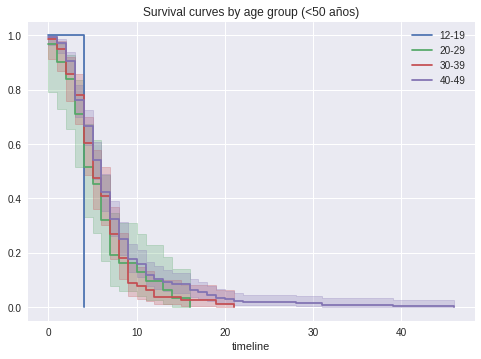

In [ ]:
ax = plt.subplot()

kmf = KaplanMeierFitter()

for age_group in group_1:
  flag = df['AGE_GROUP'] == age_group
  
  kmf.fit(T[flag], event_observed=E[flag], label=age_group)
  kmf.plot(ax=ax)
  print('Median survival time of ' + age_group + ': ' + str(kmf.median_survival_time_))

plt.title("Survival curves by age group (<50 años)");

GROUP 2

Median survival time of 50-59: 7.0
Median survival time of 60-69: 8.0
Median survival time of 70-79: 9.0
Median survival time of >80: 9.0


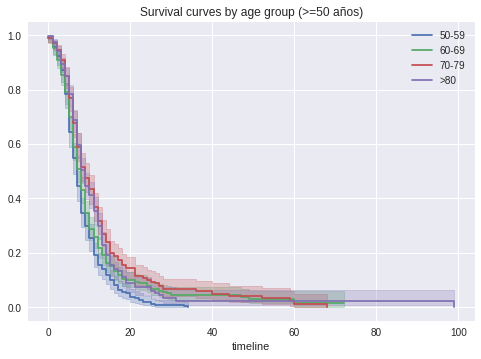

In [ ]:
ax = plt.subplot()

kmf = KaplanMeierFitter()

for age_group in group_2:
  flag = df['AGE_GROUP'] == age_group
  
  kmf.fit(T[flag], event_observed=E[flag], label=age_group)
  kmf.plot(ax=ax)
  print('Median survival time of ' + age_group + ': ' + str(kmf.median_survival_time_))

plt.title("Survival curves by age group (>=50 años)");

In [ ]:
data = {'Age group': group_1 + group_2,
        'Median survival time': [4,5,5,6,7,8,9,9]}
df_median = pd.DataFrame(data)

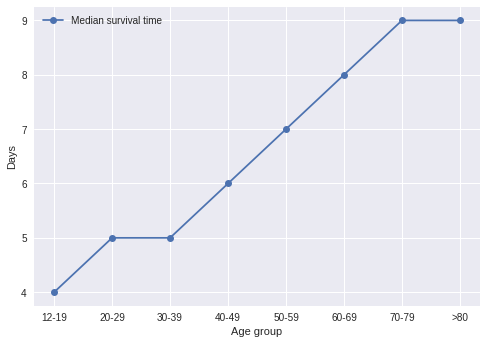

In [ ]:
df_median.plot('Age group', 'Median survival time', kind='line', style='o-', ylabel='Days')

### Logrank test

In [ ]:
results = pairwise_logrank_test(T, df['AGE_GROUP'], E)
results_df = results.summary
results_df[results_df.p>=0.05]

test_statistic         p  -log2(p)
12-19 20-29        0.558073  0.455038  1.135942
      30-39        1.349359  0.245390  2.026851
      40-49        2.183817  0.139468  2.841992
20-29 30-39        0.208079  0.648277  0.625317
      40-49        2.393749  0.121821  3.037164
30-39 40-49        2.564269  0.109303  3.193594
70-79 >80          1.107723  0.292578  1.773109

The distributions of the people younger than 50 years could be identical.
The distribution between people with 70-79 and >80 years could also be identical.

In [ ]:
results = pairwise_logrank_test(T, df['AGE_GROUP'], E)
results_df = results.summary
results_df[results_df.p<0.05]

test_statistic             p   -log2(p)
12-19 50-59        5.175348  2.290958e-02   5.447905
      60-69        5.366820  2.052337e-02   5.606589
      70-79        8.870945  2.897452e-03   8.431000
      >80          9.145651  2.493099e-03   8.647844
20-29 50-59        9.419182  2.147273e-03   8.863279
      60-69       14.793642  1.199392e-04  13.025409
      70-79       28.384399  9.946362e-08  23.261256
      >80         26.869668  2.176481e-07  22.131499
30-39 50-59       15.773977  7.137753e-05  13.774170
      60-69       28.854505  7.802421e-08  23.611503
      70-79       54.654683  1.436815e-13  42.662191
      >80         52.808625  3.676831e-13  41.306602
40-49 50-59        5.817605  1.586653e-02   5.977869
      60-69       25.881369  3.630563e-07  21.393303
      70-79       56.068667  6.998359e-14  43.699977
      >80         49.599408  1.885706e-12  38.948033
50-59 60-69        8.662113  3.248943e-03   8.265814
      70-79       34.226418  4.905842e-09  27.602852
      >80         24.691647  6.727511e-07  20.503424
60-69 70-79        8.125402  4.364931e-03   7.839825
      >80          5.099237  2.393638e-02   5.384651

Multivariate log-rank test: null hypothesis states that all the groups have the same “death” generating process, so their survival curves are identical.

In [ ]:
results = multivariate_logrank_test(T, df['AGE_GROUP'], E)
results.summary

,test_statistic,p,-log2(p)
0,141.231589,2.805792e-27,88.203651


p<0.05: Survival curves are not identical.